# About the notebook

This notebook should be ran on the server. It's in charge of training both the mean and noise digital twins, and for performing a NAS to find the best Manifold Model.
The notebook was compartmentalized so one can run each "section" without rerunning the previous sections (assuming they also run the "Import Libraries" section).

This particular notebook includes an MNIST model that can incorporate rotations in its specification

## Import libraries

In [1]:
#super basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as random
import ipdb
import copy
import itertools
import os

#torch stuff
import torch
import pytorch_lightning as pl

#analysis / software for ml
#from ana_lib.custom_plmodels import *
from ana_lib.optuna_utils import *
from ana_lib.noise import *
from ana_lib.pat_utils import *
from ana_lib.pl_callbacks import *
from ana_lib.pl_utils import *
from ana_lib.plot_utils import *
from ana_lib.process_spectrum import *
from ana_lib.torch_loader import *
from ana_lib.utils import *
from digitaltwinNAS_small_com_swish import *

    
dirname = get_dirname()

class MLP_Reg(RegressionModel):
    def __init__(self, input_dim=None, output_dim=None, Nunits=None, Ncoms=1,identity_init=1,lr=1e-3):
        super().__init__()
        self.save_hyperparameters() #this appends all the inputs into self.hparams
        for (i, Nunit) in enumerate(Nunits): #writing more attributes to hyperparams that will appear on wandb
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(Nunits) #repeat - adding Nlayers
        self.hparams['Ncoms'] = Ncoms
        self.hparams['identity_init'] = identity_init
        self.model = MLP(input_dim, output_dim, Nunits,Ncoms,identity_init) #Multilayer Perceptron pytorch model

    def forward(self, data):
        return self.model(data)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams['lr'])
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)
        scheduler = default_scheduler(lr_scheduler) #a function basically to make up for pl_lightnings fault - please use it if you want to use a scheduler
#         return optimizer
        return [optimizer], [scheduler]


C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
#exec(open("ana_lib/gpu_par.py").read())


#### Function needed generically
def get_gpu_id_new():
    return 0

## Train mean digital twins

In [3]:

#Martin you will need to change some of this stuff 
sts=np.array([525,660,780])
lens=np.array([70,410,650])
Tmaxs=np.array([100,200,300])

xdim_list=np.array([196,98,56,28])

input_dims=[196,98,56,28]
output_dims=[196,98,56,28]

In [4]:
def process_Y(y,dim):
    return digitizex(y, dim)

def train_mean_dt(input_dim, output_dim,Tmax,layerstring,NAS=False,Ntrials=10):
    name = f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_mean_data"
    data = np.load(name+".npz",allow_pickle=True)
    Y = data["specs_list"]
    xlist = data["xlist"]

    Ys=list()
    Xs=list()
    
    meancheck=0.1 #Martin! This is used to reject any random misses. So you'd need to tune this parameter if >0
    for idx in range(Y.shape[1]):
        if np.mean(np.abs(Y[0,idx][:]))>meancheck:
            Ytemp = np.mean(np.array(Y[:,idx]),axis=0)
            Ys.append(process_Y(Ytemp,output_dim))
            Xs.append(xlist[idx,:])

    Yd=np.array(Ys)
    Xd=np.array(Xs)

    Ntotal=Yd.shape[0]
    Nval=int(0.1*Ntotal) #validation
    Ntrain=Ntotal-Nval
    
    B=np.mean(Yd)
    Yng=Yd-B
    A=np.max(np.abs(Yng))
    Yng=Yng/A
    np.savez(name + 'AB.npz',A=A,B=B) #Martin, I use this to normalize the outputs - see the digital twin data collection.
    

    Yt=Yng[:Ntrain,:]
    Yv=Yng[Ntrain:Ntrain+Nval,:]

    Xt=Xd[:Ntrain,:]
    Xv=Xd[Ntrain:Ntrain+Nval,:]
    
    Nbatch=100
    
    train_dataset = TensorDataset(torch.tensor(Xt).float(), torch.tensor(Yt).float())
    val_dataset = TensorDataset(torch.tensor(Xv).float(), torch.tensor(Yv).float())
    train_loader = DataLoader(dataset=train_dataset,batch_size=Nbatch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=Nbatch)
    
    
    name = layerstring+ f"_in{input_dim}_out{output_dim}_Tmax{Tmax}"
    
    
    if NAS==True: #Only do once to get the idea of the right parameters to suggest. 
        dirname = get_dirname()
        project_name = f"{dirname}--mean_dt"  # the name that will appear in wandb
        max_epoch = 700 
        if layerstring=='l0': #Martin, my first layer is fixed 2*196-D dimensional with parameters on top, maybe change
            input_dimm=input_dim
        else:
            input_dimm=input_dim
            
        gpu_id = get_gpu_id_new()
        best_model_path=train_dig_twinNAS(Xd,Yng,input_dimm,output_dim,Ntrials,name, f"dt_models/mean_{name}.p",max_epoch,gpu_no=[gpu_id])
        mean_dt = MLP_Reg.load_from_checkpoint(best_model_path)   
        torch.save(mean_dt, f"dt_models/mean_{name}.p")        
    else:
        if layerstring == 'l0':
            model = MLP_Reg(input_dim, output_dim, [400], 2e-4) #FORCED TO BE 196!! #MARTIN!
        else:
            model = MLP_Reg(input_dim, output_dim, [210, 410], 0.0005)

        dirname = get_dirname()
        project_name = f"{dirname}--mean_dt"  # the name that will appear in wandb
        max_epoch = 800

        csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
        wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
        logger = [csv_logger, wandb_logger]

        checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
        checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

        gpu_id = get_gpu_id_new()
        #print(gpu_id)

        trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[gpu_id],
                             weights_summary=None, progress_bar_refresh_rate=0,
                             checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=50)

        trainer.fit(model, train_loader, val_loader)

        
        mean_dt = MLP_Reg.load_from_checkpoint(checkpoint_cb.kth_best_model_path)
        
        torch.save(mean_dt, f"dt_models/mean_{name}.p")
    
    x, y = next(iter(val_loader))
    
    with torch.no_grad():
        y_pred = mean_dt(x)

    plot_grid(y_pred, y, ylim=(-1.5, 1.5));
    plt.savefig(f"monitor/mean_{name}.png", dpi=500)
    if NAS==False:
        wandb_logger.experiment.join()

#use if need to restart
def kill_gpu_processes():
    [ray.cancel(x) for x in ray_objs]
    
kill_gpu_processes()

## Train noise digital twins

In [5]:
Nλ = 2 #number of eigenvectors you keep for covariance matrix
def get_A(cov):
    if cov.ndim==0:
        A= np.sqrt(np.abs(cov))
    else:
        λ, Q = np.linalg.eig(cov)
        A = np.real(Q@np.diag(np.sqrt(np.abs(λ)))[:, :Nλ])
        A /= np.sign(np.sum(A, 0))
    return A

Nbatch = 100

In [6]:
def train_noise_dt(input_dim, output_dim,Tmax,layerstring,N=2000,NAS=False,Ntrials=10):
    name = layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmax}"
    data = np.load(f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_noise_data.npz")

    specs_list = data["specs_list"][:,:N,:] #Don't use all the training data since the amount I require is probably overkill
    xlist = data["xlist"][:N,:]
    
    name2 = f"dt_data/xdim{input_dim}_Tmax{Tmax}_"+layerstring+"_mean_data"
    A=np.load(name2+'AB.npz')['A']
    B=np.load(name2+'AB.npz')['B']

    spectrums = np.array([[process_Y(s, output_dim)/A-B/A for s in specs] for specs in specs_list])
    spectrums = spectrums.swapaxes(0, 1)

    mean_data = np.mean(spectrums, axis=1)
    
    covs = np.array([np.cov(s.T) for s in spectrums])
    cov_x = np.concatenate((xlist, mean_data), axis=1)
    # cov_x = mean_data
    if output_dim>1:
        cov_data = covs.reshape(covs.shape[0], covs.shape[1]*covs.shape[2])

    As = np.array(list(map(get_A, covs)))

    A_x = np.concatenate((xlist, mean_data), axis=1)
    if output_dim>1:
        A_data = As.reshape(As.shape[0], As.shape[1]*As.shape[2])
    else:
        A_data = As
    train_loader, val_loader = np2loaders(A_x, A_data, Nbatch = 10)

    mlp_input_dim = next(iter(train_loader))[0].shape[1]
    if output_dim>1:
        mlp_output_dim = next(iter(train_loader))[1].shape[1]
    else:
        mlp_output_dim = 1
        
    dirname = get_dirname()
    project_name = f"{dirname}--noise_dt"  # the name that will appear in wandb
    
    if NAS==True: #Only do once to get the idea of the right parameters to suggest
        print('Starting NAS for digital noise twin')
        max_epoch = 1000          
        gpu_id = get_gpu_id_new()
        best_model_path=train_dig_twinNAS(A_x,A_data,mlp_input_dim,mlp_output_dim,Ntrials,name + '--noise_dt',f"dt_models/A_{name}.p",max_epoch,gpu_no=0)
        A_dt = MLP_Reg.load_from_checkpoint(best_model_path)   
        torch.save(A_dt, f"dt_models/A_{name}.p") ##note martin: we need to save the MLP_Reg object, not just the model! Here and above in the digital twin.     
    else:
        print('Training default model for noise twin')
        max_epoch = 200
        model = MLP_Reg(mlp_input_dim, mlp_output_dim, [600], 0.5e-4)
        #model = MLP_Reg(mlp_input_dim, mlp_output_dim, [1000,500,500], 0.5e-4)
        
        #logger stuff
        csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
        wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
        logger = [csv_logger, wandb_logger]

        #checkpoint
        checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
        checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

        gpu_id = get_gpu_id_new()

        trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[gpu_id],
                             weights_summary=None, progress_bar_refresh_rate=0,
                             checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=4)

        trainer.fit(model, train_loader, val_loader)
        wandb_logger.experiment.join()

        A_dt = MLP_Reg.load_from_checkpoint(checkpoint_cb.kth_best_model_path)
     
        torch.save(A_dt, f"dt_models/A_{name}.p") ##note martin: we need to save the MLP_Reg object, not just the model! Here and above in the digital twin. 

    x, y = next(iter(val_loader))
    with torch.no_grad():
        y_pred = A_dt(x)

    cov_train_loader, cov_val_loader = np2loaders(A_x, covs, Nbatch=10)
    x_cov, y_cov = next(iter(cov_val_loader))
    if output_dim>1:
        fig, axs = plt.subplots(4, 2, figsize=(10, 8))

        for j in range(2):
            for ind in range(4):
                plt.sca(axs[ind, j])
                plt.plot(y[ind].reshape(output_dim, Nλ)[:, j],label='actual')
                plt.plot(y_pred[ind].reshape(output_dim, Nλ)[:, j],label='predicted')
        plt.legend()

        axs[0,0].set_title("A_1")
        axs[0,1].set_title("A_2")
        fig.savefig(f"monitor/A_{name}.png", dpi=200, bbox_inches="tight" )

        fig, axs = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
        plt.subplots_adjust(hspace=0.05, wspace=0.02)
        problem_inds = [0, 1, 2]
        for (x_ind, p_ind) in enumerate(problem_inds):
            A_pred = y_pred[p_ind].reshape(output_dim, Nλ)

            cov_val = y_cov[p_ind]
            cov_pred = A_pred@A_pred.T
            vmax = 2*cov_val.max()

            plt.sca(axs[x_ind, 0])
            plt.imshow(cov_val, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

            plt.sca(axs[x_ind, 1])
            plt.imshow(cov_pred, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

            plt.sca(axs[x_ind, 2])
            plt.imshow(cov_val-cov_pred, cmap="coolwarm", vmax=vmax, vmin=-vmax)
            plt.colorbar()

        axs[0, 0].set_title("val cov")
        axs[0, 1].set_title("pred cov")
        axs[0, 2].set_title("val cov - pred cov")
        fig.savefig(f"monitor/cov_{name}.png", dpi=200, bbox_inches="tight" )

## NAS for Manifold Models

In [7]:
def relu_approx(x, factor=20.0):
    """
    A soft-relu function
    The default factor of 20.0 is descent for a turn on at around -0.1 
    """
    return F.softplus(x*factor)/factor
def clamp_lag(x, low=-1.0, high=1.0, factor=20): 
    """
    Lagrangian loss term to clamp the value of x between low and high.
    To play around with this code do:
    xlist = torch.tensor(np.linspace(-1, 2, 100))
    ylist = [clamp_lag(x, low=0, high=1, factor=20) for x in xlist]
    plt.plot(xlist, ylist)
    plt.grid()
    """
    return torch.mean(relu_approx(-(x-low), factor) + relu_approx(x-high, factor)) 
        
class ManifoldPlModelMNIST(ClassificationLagPlModel):
    def __init__(self, flist, dims,rot,lr,device,optimizer_name,gap, lag_amp=2.5, lag_factor=30.0):
        super().__init__()
        self.save_hyperparameters()
        #delete flist since it is a function which cannot be saved as JSON and will cause a bug...
        del self.hparams["flist"] 
        # writing more attributes to hyperparams that will appear on wandb
        for (i, Nunit) in enumerate(dims):
            self.hparams[f'ldim_{i}'] = Nunit
        self.hparams['Nlayers'] = len(dims[0])  #adding Nlayers
        self.hparams['Nchannels'] = len(dims) 
        self.hparams['optimizer']= optimizer_name
        self.hparams['gap']= gap
        self.factors = nn.ParameterList()
        self.offsets = nn.ParameterList()
        self.dims = dims
        self.rot = rot
        #self.ils = nn.ModuleList()
        #self.Ms = list()
        self.output_scale = nn.Parameter(torch.ones(1))
        self.output_offset  = nn.Parameter(torch.zeros(1))      

        N_channels = len(dims)
        self.N_channels = N_channels
        N_layers = len(dims[0])-1
        self.N_layers = N_layers
        
        #for n in range(N_channels):
        #    M=torch.zeros([196*2,dims[n][0]],requires_grad=False).float().to(device)
        #    idx2=0
        #    idx3=0
        #    for idx in range(2*196):
        #        M[idx,idx3]=1.
        #        idx2+=1
        #        if np.mod(idx2,2*196//dims[n][0])==0:
        #            idx3+=1
        #    
        #    self.Ms.append(M)
        
        
        dim_out = 0
        for n in range(N_channels):
            nlayers = len(flist)
            for dim in dims[n][:-1]:
                self.factors.append(nn.Parameter(torch.ones(dim)*0.9))
                self.offsets.append(nn.Parameter(torch.zeros(dim)))


            dim_out +=dims[n][-1]-2*gap
            
        self.flist = flist
        self.xPLMs = []
        
        self.gap=gap
        self.en=dims[-1][-1]-gap
                                        
        #self.il=nn.Linear(196,dims[0][0])
        #for dim in dims:
        #    self.ils.append(nn.Linear(196,dim[0]//2))
            
        self.ol = nn.Linear(dim_out,10)
        
        self.OL = torch.zeros([100,10],requires_grad=False).float().to(device) 
        
        n2=0
        for n1 in range(100):         
            if np.mod(n1,100//10) == 0 and n1 !=0:
                n2+=1               
            self.OL[n1,n2]=1
        print(self.OL)         
    
    def forward(self, x, save=False):
        
        self.xin = []
        self.xout = []
            
        #bnldx=0
        x0=x
        fdx=0
        for n in range(self.N_channels):
            for l in range(self.N_layers):        
                ldx=l+n*self.N_layers
                if l==0:
                    if self.rot[n]==True:
                        x0p = torch.reshape(x0,(x0.shape[0],14,14))
                        x0p = torch.rot90(x0p,1,[1,2])
                        x0p = torch.reshape(x0p,(x0.shape[0],196))
                        
                        x=x0p*self.factors[ldx]+self.offsets[ldx]
                    else:
                        x=x0*self.factors[ldx]+self.offsets[ldx]
                    self.xin.append(x)
                    #x = x*torch.matmul(self.Ms[n],self.factors[ldx])+torch.matmul(self.Ms[n],self.offsets[ldx])    
                else:
                    x=x*self.factors[ldx]+self.offsets[ldx]
                    self.xin.append(x) #MODIFIED FOR THE LAGRANGIAN
                    fdx+=1
                    
                x = x.clamp(-1, 1)
                x = self.flist[ldx](x)#+xin
                
                self.xout.append(x.detach())

            if n==0:
                xout=x[:,self.gap:self.en]#torch.cat([x0,x],dim=1)
            else:
                xout=torch.cat([xout,x[:,self.gap:self.en]],dim=1)

        #x = F.softmax(self.ol(xout),dim=1)
        x = torch.matmul(self.output_scale*xout/torch.max(xout,dim=1,keepdim=True).values+self.output_offset,self.OL)
        return x                 
    
    def lagrangian(self):
        """
        The lagrangian function that will be added to the loss.
        """
        lag_layers = [self.hparams.lag_amp*clamp_lag(x, -1.0, 1.0, self.hparams.lag_factor) for x in self.xin]
        #use stack to convert python list to pytorch tensor, then take the mean
        out = torch.mean(torch.stack(lag_layers))
        return out    
        
    
    def configure_optimizers(self):
        if self.hparams['optimizer'] == 'Adam':
            optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        elif self.hparams['optimizer'] == 'Adadelta':
            optimizer = optim.Adadelta(self.parameters())
        elif self.hparams['optimizer'] == 'SGD':
            optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,momentum=0.9)
        elif self.hparams['optimizer'] == 'Adagrad':            
            optimizer = optim.Adagrad(self.parameters(), lr=self.hparams.lr, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
        elif self.hparams['optimizer'] == 'ASGD':    
            optimizer = optim.ASGD(self.parameters(), lr=self.hparams.lr, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay=0)
        elif self.hparams['optimizer'] == 'SGD_LRdecay':          
            optimizer = optim.SGD(self.parameters(),lr=self.hparams.lr,momentum=0.9)
            torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.01, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False) 
        return optimizer       
    

In [8]:
"""
Functions that will be used in this cell...
"""
Nλ = 2
def get_dt(input_dim, output_dim, layerstring,idt,device):
    """
    Construct the digital twin function that has outputs mean with the noise added.
    Note, if don't want noise digital twin just return mean_dt
    """
    dtpath="dt_models/mean_"+layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmaxs[idt]}.p"
    if os.path.isfile(dtpath):
        print('Model already exists for '+ dtpath)
        mean_dt = torch.load(dtpath).to(device)          
    else:
        print('Need to train model for ' + dtpath)
        train_mean_dt(input_dim,output_dim,Tmaxs[idt],layerstring,NAS=True,Ntrials=50)
        mean_dt = torch.load(dtpath).to(device)
        
    for param in mean_dt.parameters():
        param.requires_grad = False
        
    dtpath="dt_models/A_"+layerstring+f"_in{input_dim}_out{output_dim}_Tmax{Tmaxs[idt]}.p"  
    if os.path.isfile(dtpath):
        print('Model already exists for '+ dtpath)
        A_dt = torch.load(dtpath).to(device)
    else:
        print('Need to train model for ' + dtpath)
        train_noise_dt(input_dim,output_dim,Tmaxs[idt],layerstring,NAS=True,Ntrials=50)
        A_dt = torch.load(dtpath).to(device)
        
    for param in A_dt.parameters():
        param.requires_grad = False   
        
    f = make_dt_func(mean_dt, A_dt, output_dim, Nλ)
    return f

def train_model(project_name,name, dims, idts,rot,lr,max_epoch,train_loader,val_loader,ir,optimizer_name,path='None',gap=8):
    device = get_gpu_id_new()
    flist = list()
    for n in range(len(dims)):
        for l in range(len(dims[n])-1):
            flist.append(get_dt(dims[n][l], dims[n][l+1], 'l1',idts[n][l],device))
    model = ManifoldPlModelMNIST(flist, dims,rot,lr,device,optimizer_name,gap)
    print(model)
    
    if path!='None':
        model.load_state_dict(torch.load('NAS_run' + str(ir) +'.p'))

    #logger stuff
    csv_logger = pl.loggers.CSVLogger('logs', project_name, name)
    wandb_logger = pl.loggers.WandbLogger(name=name, project=project_name)
    logger = [csv_logger, wandb_logger]

    #checkpoint models
    checkpoint_file = os.path.join(csv_logger.log_dir, "{epoch}-{val_loss:.5f}")
    checkpoint_cb = pl.callbacks.ModelCheckpoint(checkpoint_file)

    trainer = pl.Trainer(max_epochs=max_epoch, logger=logger, gpus=[device],
                         weights_summary=None, progress_bar_refresh_rate=0,
                         checkpoint_callback=checkpoint_cb, log_save_interval=50, row_log_interval=4)

    trainer.fit(model, train_loader, val_loader)
    model.to(device) #trainer apparently changes it to cpu type all the time...

    #Run the same model many times since the noise creates maxima in the training
    accuracies, losses = test_plmodel(model, val_loader, Nrepeat=3)
    mean_accuracy = np.mean(accuracies)
    mean_loss = np.mean(losses)
    metrics = dict(epoch=trainer.current_epoch, 
                   val_accu_end=mean_accuracy,  val_loss_end=mean_loss)
    trainer.logger.log_metrics(metrics, step=trainer.global_step)
    wandb_logger.experiment.join()
    
    torch.save(model.state_dict(),'NAS_run' + str(ir) +'.p')
    
    return mean_accuracy, mean_loss, checkpoint_cb.kth_best_model_path

batch_size=50
from torchvision.datasets import MNIST
import torch
from torchvision import transforms
compress_factor=2
reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))

transforms_noise = transforms.Compose([transforms.RandomAffine(15, translate=(0.0, 0.05), scale=(0.9, 1.1)), transforms.ToTensor(),  reshape_f])
train_loader = torch.utils.data.DataLoader(MNIST('.', train=True, download=True, transform=transforms_noise), batch_size=batch_size, shuffle=True)
transforms_noise = transforms.Compose([transforms.ToTensor(),  reshape_f])
val_loader = torch.utils.data.DataLoader(MNIST('.', train=False, download=True, transform=transforms_noise),batch_size=batch_size, shuffle=True) 

v=val_loader.dataset.data

reshape_f = lambda x: torch.reshape(x[0, ::compress_factor, ::compress_factor], (-1, ))
transform = transforms.Compose([transforms.ToTensor(), reshape_f])

compress_factor = 2 #Use either 1, 2 or 4! 
x = v[:, ::compress_factor, ::compress_factor]
x = x.reshape(x.shape[0], x.shape[1]**2)

y = val_loader.dataset.targets

yn=np.array(y)
xn=np.array(x)
xn=xn*1.0/255


Nval=6000//1
Ntest=(xn.shape[1]-Nval)//1

Xv=xn[:Nval,:]
Xtest=xn[Nval:,:]

Yv=yn[:Nval]
Ytest=yn[Nval:]


val_dataset = TensorDataset(torch.tensor(Xv).float(), torch.tensor(Yv))
test_dataset = TensorDataset(torch.tensor(Xtest).float(), torch.tensor(Ytest))

val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

In [9]:

Tmaxs=np.array([270])

input_dims=[196,98,56,28]
output_dims=[196,98,56,28]
project_name = 'DT_MNIST_NAS_dec28_'

[I 2021-03-17 08:28:00,118] Using an existing study with name '' instead of creating a new one.
wandb: Currently logged in as: pnn (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100v16sumSwish\v24 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,9e-05
_step,8399
_runtime,1590
_timestamp,1615985673
train_loss,0.08775
epoch,699
val_loss,0.11226


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,████████████████████████▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[I 2021-03-17 08:54:37,061] Trial 24 finished with value: 0.012602088041603565 and parameters: {'Nlayers': 4, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 215.78427637685783, 'Nunits2': 229.53205441203767, 'Nunits3': 182.60689364866798}. Best is trial 18 with value: 0.011677253060042858.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100v16sumSwish\v25 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,0.0001
_step,8399
_runtime,2400
_timestamp,1615988077
train_loss,0.11158
epoch,699
val_loss,0.13949


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▇▇▆▇▆▆▆▆▆▆▅▅▅▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[I 2021-03-17 09:34:41,112] Trial 25 finished with value: 0.0194577407091856 and parameters: {'Nlayers': 4, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 191.22598328823273, 'Nunits2': 183.5001622307182, 'Nunits3': 232.55573064904794}. Best is trial 18 with value: 0.011677253060042858.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100v16sumSwish\v26 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,377999
lr-Adam,0.0
_step,8399
_runtime,3001
_timestamp,1615991082
train_loss,0.07549
epoch,699
val_loss,0.11611


global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr-Adam,███▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


[I 2021-03-17 10:24:45,718] Trial 26 finished with value: 0.013479833491146564 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 166.1329132091407, 'Nunits2': 245.31046866045898, 'Nunits3': 182.76605443500355, 'Nunits4': 241.05630130787708}. Best is trial 18 with value: 0.011677253060042858.
[I 2021-03-17 10:25:17,667] A new study created in RDB with name: 


Starting NAS for digital noise twin


wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,149
_timestamp,1615991266
val_loss,0.01341
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:27:49,628] Trial 0 finished with value: 0.0001753587566781789 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.0031, 'Nunits1': 792.1582752859158, 'Nunits2': 250.14660382735244}. Best is trial 0 with value: 0.0001753587566781789.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,241
_timestamp,1615991510
val_loss,0.01312
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:31:53,414] Trial 1 finished with value: 0.0001720364816719666 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 395.97511401927153, 'Nunits2': 348.5624477804435, 'Nunits3': 217.62770448486006}. Best is trial 1 with value: 0.0001720364816719666.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v2 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,147
_timestamp,1615991660
val_loss,0.01283
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:34:23,323] Trial 2 finished with value: 0.00016460614278912544 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 561.634493534587, 'Nunits2': 354.59304251599747}. Best is trial 2 with value: 0.00016460614278912544.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v3 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,96
_timestamp,1615991759
val_loss,0.01343
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:36:02,518] Trial 3 finished with value: 0.00018006612663157284 and parameters: {'Nlayers': 5, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 222.9707748349737, 'Nunits2': 211.22484441632918, 'Nunits3': 176.45622329019457, 'Nunits4': 158.1671880924127}. Best is trial 2 with value: 0.00016460614278912544.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v4 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,160
_timestamp,1615991922
val_loss,0.01416
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:38:46,074] Trial 4 finished with value: 0.000196272085304372 and parameters: {'Nlayers': 5, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 344.3219778263531, 'Nunits2': 195.0276057641772, 'Nunits3': 186.98461500850055, 'Nunits4': 199.32160501512072}. Best is trial 2 with value: 0.00016460614278912544.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v5 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,58
_timestamp,1615991984
val_loss,0.01242
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:39:47,189] Trial 5 finished with value: 0.00015404123405460268 and parameters: {'Nlayers': 2, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 293.8599289289626}. Best is trial 5 with value: 0.00015404123405460268.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v6 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,571
_timestamp,1615992558
val_loss,0.01393
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
val_loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:49:21,745] Trial 6 finished with value: 0.00019391487876418978 and parameters: {'Nlayers': 4, 'Ncoms': 4, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 583.7859381338217, 'Nunits2': 536.9381637315877, 'Nunits3': 197.638325600909}. Best is trial 5 with value: 0.00015404123405460268.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v7 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,91
_timestamp,1615992652
val_loss,0.01318
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:50:55,279] Trial 7 finished with value: 0.00017233572725672275 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 369.588888663676, 'Nunits2': 388.4041610575147}. Best is trial 5 with value: 0.00015404123405460268.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v8 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,181
_timestamp,1615992836
val_loss,0.01359
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:53:59,445] Trial 8 finished with value: 0.0001828910899348557 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 156.46075599069, 'Nunits2': 365.5043375433318, 'Nunits3': 179.13981809930306}. Best is trial 5 with value: 0.00015404123405460268.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v9 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,159
_timestamp,1615992998
val_loss,0.01286
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:56:41,758] Trial 9 finished with value: 0.00016468402463942766 and parameters: {'Nlayers': 4, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 757.7788704990654, 'Nunits2': 194.02186297210667, 'Nunits3': 195.65928712562862}. Best is trial 5 with value: 0.00015404123405460268.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v10 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615993041
val_loss,0.01153
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:57:24,887] Trial 10 finished with value: 0.00013303715968504548 and parameters: {'Nlayers': 1, 'Ncoms': 3, 'identity_init': 0, 'lr': 0.01}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v11 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,121
_timestamp,1615993165
val_loss,0.01315
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 10:59:28,176] Trial 11 finished with value: 0.00016969928401522338 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 535.838994690659, 'Nunits2': 577.7425001126031}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v12 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,247
_timestamp,1615993415
val_loss,0.01338
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:03:38,304] Trial 12 finished with value: 0.00016231616609729826 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 327.0488938549834, 'Nunits2': 593.4393657347157, 'Nunits3': 244.32407517662267}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v13 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,288
_timestamp,1615993706
val_loss,0.01307
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:08:29,268] Trial 13 finished with value: 0.00016653623606543988 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.000456, 'Nunits1': 218.83280096813027, 'Nunits2': 381.22452579214104, 'Nunits3': 183.46052594653972, 'Nunits4': 168.3745619348763}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v14 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,95
_timestamp,1615993804
val_loss,0.01459
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:10:08,122] Trial 14 finished with value: 0.0001924729294842109 and parameters: {'Nlayers': 2, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 641.9607970252811}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v15 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615993848
val_loss,0.01161
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:10:52,260] Trial 15 finished with value: 0.00013471971033141017 and parameters: {'Nlayers': 1, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.000456}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v16 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,296
_timestamp,1615994148
val_loss,0.01406
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:15:52,072] Trial 16 finished with value: 0.00017862558888737112 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 236.27040749379992, 'Nunits2': 163.84036352939094, 'Nunits3': 211.80844100893603, 'Nunits4': 240.89608047044325}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v17 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,55
_timestamp,1615994207
val_loss,0.01258
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:16:51,033] Trial 17 finished with value: 0.00015626738604623824 and parameters: {'Nlayers': 2, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.01, 'Nunits1': 223.24359484114737}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v18 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,717
_timestamp,1615994928
val_loss,0.01273
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███████████▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:28:51,393] Trial 18 finished with value: 0.00016200775280594826 and parameters: {'Nlayers': 3, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 741.9133749305978, 'Nunits2': 728.7873844293424}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v19 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,108
_timestamp,1615995039
val_loss,0.01288
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:30:42,364] Trial 19 finished with value: 0.00016568721912335604 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 355.80710070904894, 'Nunits2': 494.35210523842255}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v20 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,74
_timestamp,1615995116
val_loss,0.01268
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:31:59,960] Trial 20 finished with value: 0.00016018198220990598 and parameters: {'Nlayers': 2, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 196.22573913456003}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v21 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,374
_timestamp,1615995494
val_loss,0.01385
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████████████▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
val_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:38:17,971] Trial 21 finished with value: 0.00019183047697879374 and parameters: {'Nlayers': 4, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 397.8039741258477, 'Nunits2': 378.5542543707648, 'Nunits3': 161.76464165065042}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v22 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,128
_timestamp,1615995626
val_loss,0.01309
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███████████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:40:29,549] Trial 22 finished with value: 0.00017145703895948827 and parameters: {'Nlayers': 3, 'Ncoms': 3, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 194.44921367305255, 'Nunits2': 240.0617827996588}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v23 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,113
_timestamp,1615995742
val_loss,0.01336
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:42:25,425] Trial 23 finished with value: 0.00017103063873946667 and parameters: {'Nlayers': 4, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 611.4863004520622, 'Nunits2': 352.56225372278556, 'Nunits3': 228.13117325626698}. Best is trial 10 with value: 0.00013303715968504548.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v24 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,39
_timestamp,1615995784
val_loss,0.01152
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:43:07,748] Trial 24 finished with value: 0.0001326845376752317 and parameters: {'Nlayers': 1, 'Ncoms': 2, 'identity_init': 0, 'lr': 0.0031}. Best is trial 24 with value: 0.0001326845376752317.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v25 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,154
_timestamp,1615995941
val_loss,0.01213
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:45:44,479] Trial 25 finished with value: 0.00014713755808770657 and parameters: {'Nlayers': 2, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 712.88678066906}. Best is trial 24 with value: 0.0001326845376752317.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v26 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,40
_timestamp,1615995984
val_loss,0.01155
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:46:27,533] Trial 26 finished with value: 0.000133460751385428 and parameters: {'Nlayers': 1, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.000456}. Best is trial 24 with value: 0.0001326845376752317.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v27 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,148
_timestamp,1615996135
val_loss,0.0138
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:48:59,051] Trial 27 finished with value: 0.0001901845826068893 and parameters: {'Nlayers': 4, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.001, 'Nunits1': 495.8495027895214, 'Nunits2': 268.9104136101988, 'Nunits3': 168.21333783783567}. Best is trial 24 with value: 0.0001326845376752317.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v28 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,38
_timestamp,1615996177
val_loss,0.01151
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:49:40,546] Trial 28 finished with value: 0.0001325897464994341 and parameters: {'Nlayers': 1, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.01}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v29 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,175
_timestamp,1615996355
val_loss,0.01326
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:52:38,791] Trial 29 finished with value: 0.00017584599845577031 and parameters: {'Nlayers': 5, 'Ncoms': 2, 'identity_init': 0, 'lr': 1e-05, 'Nunits1': 226.52246372097454, 'Nunits2': 429.7935802002897, 'Nunits3': 163.5307525076693, 'Nunits4': 170.62726324370746}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v30 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,207
_timestamp,1615996565
val_loss,0.01461
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:56:08,326] Trial 30 finished with value: 0.00021343142725527287 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 193.11618023604603, 'Nunits2': 443.25859316008444, 'Nunits3': 187.9954295448239}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v31 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,90
_timestamp,1615996658
val_loss,0.01302
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:57:46,117] Trial 31 finished with value: 0.00015660011558793485 and parameters: {'Nlayers': 3, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 407.816769316735, 'Nunits2': 492.59146516238474}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v32 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,8e-05
_step,1999
_runtime,38
_timestamp,1615996704
val_loss,0.01161
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 11:58:27,597] Trial 32 finished with value: 0.00013488186232279986 and parameters: {'Nlayers': 1, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.01}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v33 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,108
_timestamp,1615996815
val_loss,0.01346
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:00:19,050] Trial 33 finished with value: 0.00018122719484381378 and parameters: {'Nlayers': 5, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 337.5517592353246, 'Nunits2': 370.53103147868217, 'Nunits3': 152.87820292407875, 'Nunits4': 217.1579960459324}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v34 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,87
_timestamp,1615996906
val_loss,0.01362
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████████████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:01:49,965] Trial 34 finished with value: 0.00018550033564679325 and parameters: {'Nlayers': 5, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 214.57616610941568, 'Nunits2': 168.37532126603872, 'Nunits3': 208.29822293079278, 'Nunits4': 217.97166208088345}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v35 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,196
_timestamp,1615997106
val_loss,0.01293
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:05:09,429] Trial 35 finished with value: 0.00016703997971490026 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.0001, 'Nunits1': 173.05185304617976, 'Nunits2': 182.19956387100157, 'Nunits3': 187.7934963156381, 'Nunits4': 177.02597157640508}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v36 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,80
_timestamp,1615997189
val_loss,0.01236
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:06:32,504] Trial 36 finished with value: 0.00015282379172276706 and parameters: {'Nlayers': 2, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.0031, 'Nunits1': 266.8068785510261}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v37 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,104
_timestamp,1615997296
val_loss,0.0126
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:08:20,047] Trial 37 finished with value: 0.00015875320241320878 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 345.31591355802135, 'Nunits2': 527.1331724645833}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v38 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,46
_timestamp,1615997346
val_loss,0.01254
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:09:09,423] Trial 38 finished with value: 0.00015581732441205531 and parameters: {'Nlayers': 2, 'Ncoms': 1, 'identity_init': 0, 'lr': 0.001, 'Nunits1': 352.05573855835826}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v39 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,270
_timestamp,1615997619
val_loss,0.01387
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,████████████▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:13:42,688] Trial 39 finished with value: 0.00019236050138715655 and parameters: {'Nlayers': 5, 'Ncoms': 5, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 318.3293407154216, 'Nunits2': 168.908712353246, 'Nunits3': 216.83703212712604, 'Nunits4': 174.9703408226766}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v40 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,35
_timestamp,1615997657
val_loss,0.02091
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
val_loss,█▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:14:20,543] Trial 40 finished with value: 0.0004373663105070591 and parameters: {'Nlayers': 1, 'Ncoms': 2, 'identity_init': 0, 'lr': 1e-05}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v41 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,251
_timestamp,1615997911
val_loss,0.01343
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:18:34,630] Trial 41 finished with value: 0.0001803540508262813 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 360.007249266173, 'Nunits2': 384.4121004217258, 'Nunits3': 219.50558090524297, 'Nunits4': 219.82553918176959}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v42 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,79
_timestamp,1615997993
val_loss,0.01372
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:19:56,386] Trial 42 finished with value: 0.0001881172793218866 and parameters: {'Nlayers': 5, 'Ncoms': 1, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 305.8303411087078, 'Nunits2': 172.21609764700054, 'Nunits3': 193.4042124414675, 'Nunits4': 187.04339576640646}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v43 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,237
_timestamp,1615998233
val_loss,0.01396
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:23:56,912] Trial 43 finished with value: 0.00019012487609870732 and parameters: {'Nlayers': 5, 'Ncoms': 4, 'identity_init': 0, 'lr': 0.01, 'Nunits1': 183.15431861082874, 'Nunits2': 527.7994367724199, 'Nunits3': 180.8711327881743, 'Nunits4': 166.92304911282872}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v44 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,85
_timestamp,1615998321
val_loss,0.01379
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,██▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:25:24,670] Trial 44 finished with value: 0.00018675382307264954 and parameters: {'Nlayers': 2, 'Ncoms': 5, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 197.3402829878776}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v45 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,156
_timestamp,1615998480
val_loss,0.01387
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:28:03,967] Trial 45 finished with value: 0.0001713873934932053 and parameters: {'Nlayers': 4, 'Ncoms': 3, 'identity_init': 0, 'lr': 0.0031, 'Nunits1': 502.4704174304467, 'Nunits2': 187.743223621079, 'Nunits3': 249.40817494219644}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v46 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,122
_timestamp,1615998606
val_loss,0.01321
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,███▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:30:10,077] Trial 46 finished with value: 0.00017459712398704141 and parameters: {'Nlayers': 4, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.000456, 'Nunits1': 314.10426330797503, 'Nunits2': 392.79584684571876, 'Nunits3': 219.7751598329322}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v47 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,1e-05
_step,1999
_runtime,104
_timestamp,1615998714
val_loss,0.01452
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:31:58,089] Trial 47 finished with value: 0.00021083973115310073 and parameters: {'Nlayers': 2, 'Ncoms': 4, 'identity_init': 1, 'lr': 1e-05, 'Nunits1': 589.2725656604832}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v48 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0
_step,1999
_runtime,93
_timestamp,1615998811
val_loss,0.01345
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,█████████████████▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:33:34,233] Trial 48 finished with value: 0.0001809710229281336 and parameters: {'Nlayers': 3, 'Ncoms': 2, 'identity_init': 1, 'lr': 0.0001, 'Nunits1': 492.3288681888368, 'Nunits2': 187.2157773137656}. Best is trial 28 with value: 0.0001325897464994341.
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
C:\Users\lgw32\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Experiment logs directory logs\l0iid_in70_out70_Tmax100--noise_dtv16sumSwish\v49 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


global_step,17999
lr-Adam,0.0001
_step,1999
_runtime,35
_timestamp,1615998849
val_loss,0.01168
epoch,999


global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


[I 2021-03-17 12:34:12,484] Trial 49 finished with value: 0.00013652890629600734 and parameters: {'Nlayers': 1, 'Ncoms': 4, 'identity_init': 1, 'lr': 0.0001}. Best is trial 28 with value: 0.0001325897464994341.


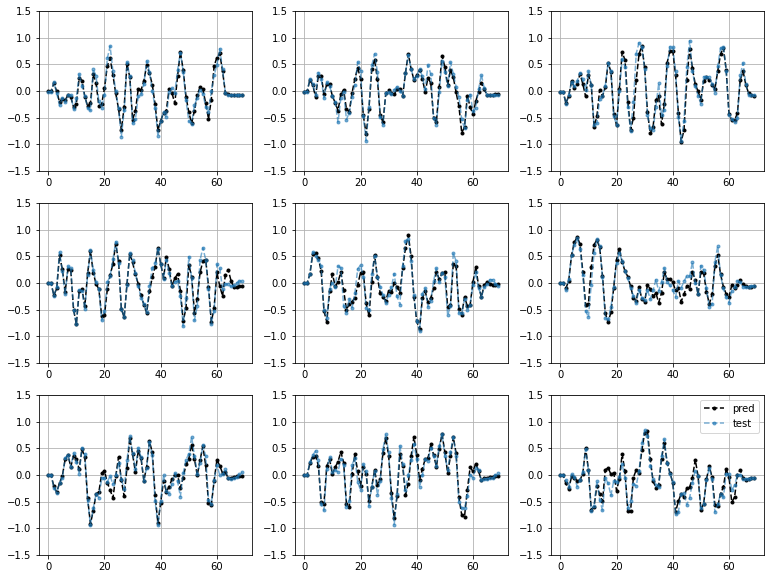

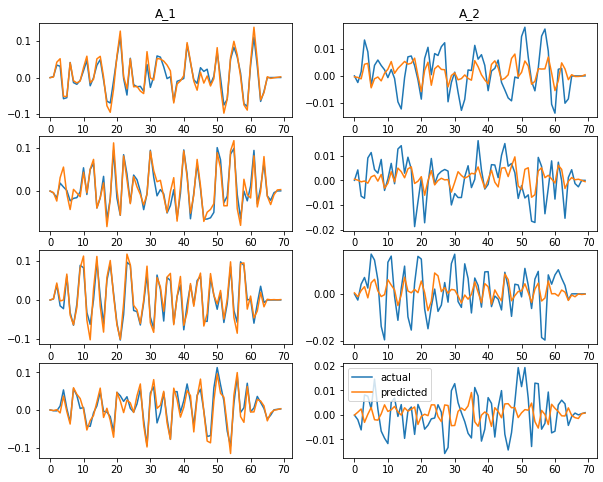

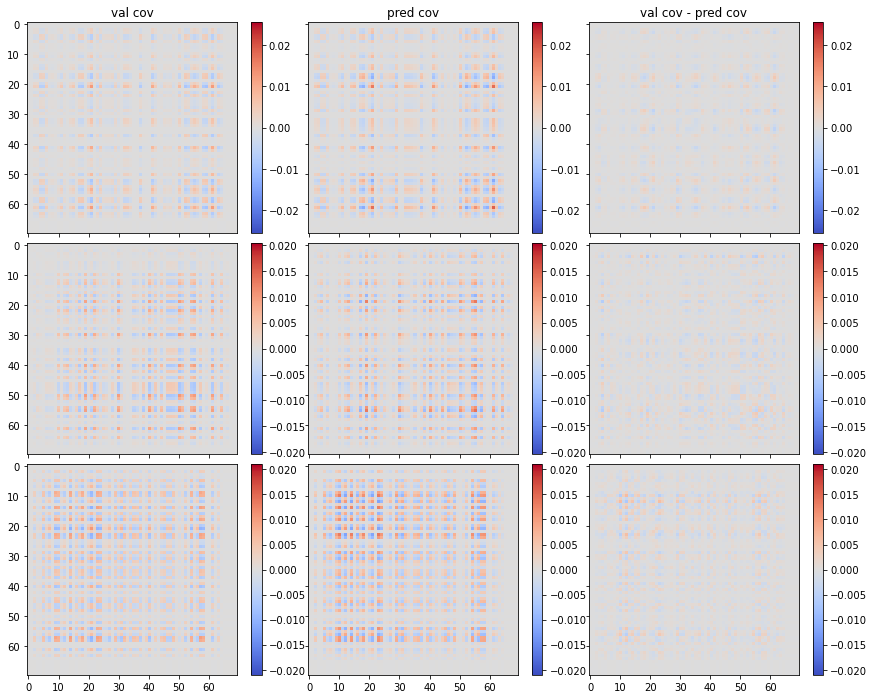

In [10]:
input_dim=70
output_dim=70
layerstring='l0iid'
idt=0
train_mean_dt(input_dim,output_dim,100,layerstring,NAS=True,Ntrials=3)
train_noise_dt(input_dim,output_dim,100,layerstring,NAS=True,Ntrials=50)